In [862]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [863]:
import features # custom helper package

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Read data

In [864]:
ames = pd.read_csv("../data/engineered.csv")
ames.drop("Unnamed: 0", axis=1, inplace=True)

Select target and features for X to regress on

In [865]:
model = LinearRegression()

target = ames.LogSalePrice
X = ames[[
    # Size
    'GrLivArea', 'TotalFinBsmtSF', 'TotalOutdoorSF', 'LotArea', 'BedroomAbvGr',
    # Type
    'MSSubClass', 'MSZoning',
    # Niceness
    'OverallQual', 'OverallCond', 'Neighborhood', 'KitchenQual',
    # Sale
    'SaleCondition', 'YrSold',
    # Features
    'CentralAir', 'Fireplaces', 'HasPool',
    # Others
    'IsNearNegativeCondition', 'LandContour'
]]
X

,GrLivArea,TotalFinBsmtSF,TotalOutdoorSF,LotArea,BedroomAbvGr,MSSubClass,MSZoning,OverallQual,OverallCond,Neighborhood,KitchenQual,SaleCondition,YrSold,CentralAir,Fireplaces,HasPool,IsNearNegativeCondition,LandContour
0,856,238.0,166,7890,2,Dwelling_30,RL,6,6,SWISU,3,Normal,Yr_2010,Y,1,0,0,Lvl
1,1049,945.0,105,4235,2,Dwelling_120,RL,5,5,Edwards,4,Normal,Yr_2009,Y,0,0,0,Lvl
2,1001,737.0,196,6060,2,Dwelling_30,C (all),5,9,IDOTRR,4,Normal,Yr_2007,Y,0,0,0,Lvl
3,1039,0.0,279,8146,2,Dwelling_70,RL,4,8,OldTown,3,Normal,Yr_2009,Y,0,0,0,Lvl
4,1665,643.0,45,8400,3,Dwelling_60,RL,8,6,NWAmes,4,Normal,Yr_2009,Y,0,0,0,Lvl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,952,0.0,138,8854,2,Dwelling_30,RL,6,6,BrkSide,2,Normal,Yr_2009,N,1,0,0,Lvl
2573,1733,0.0,0,13680,4,Dwelling_20,RL,3,5,Edwards,3,Normal,Yr_2009,Y,1,0,0,Lvl
2574,2002,284.0,0,6270,4,Dwelling_90,RH,5,6,Crawfor,3,Normal,Yr_2007,N,0,0,0,HLS
2575,1842,841.0,289,8826,3,Dwelling_60,RL,7,5,CollgCr,4,Normal,Yr_2007,Y,1,0,0,Lvl


Check correlations

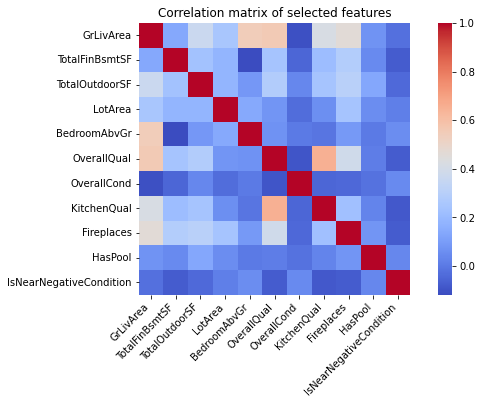

In [866]:
heatmap = sns.heatmap(X.corr(), cmap='coolwarm', square=True)
plt.title('Correlation matrix of selected features')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Encode categorical features

In [867]:
# All possible features
all_categorical_features = set(features.get_categorical_features())
all_numerical_features = set(features.get_numerical_features())

# What are the categorical + numerical features in X
X_categorical_features = list(all_categorical_features.intersection(set(X.columns)))
X_numerical_features = list(all_numerical_features.intersection(set(X.columns)))
X_features = X_categorical_features + X_numerical_features

# Dummify categorical features from all features selected for our model
X = pd.get_dummies(X, columns=X_categorical_features, prefix=X_categorical_features, drop_first=True)
X

,GrLivArea,TotalFinBsmtSF,TotalOutdoorSF,LotArea,BedroomAbvGr,OverallQual,OverallCond,KitchenQual,Fireplaces,HasPool,...,MSSubClass_Dwelling_85,MSSubClass_Dwelling_90,LandContour_HLS,LandContour_Low,LandContour_Lvl,YrSold_Yr_2007,YrSold_Yr_2008,YrSold_Yr_2009,YrSold_Yr_2010,CentralAir_Y
0,856,238.0,166,7890,2,6,6,3,1,0,...,0,0,0,0,1,0,0,0,1,1
1,1049,945.0,105,4235,2,5,5,4,0,0,...,0,0,0,0,1,0,0,1,0,1
2,1001,737.0,196,6060,2,5,9,4,0,0,...,0,0,0,0,1,1,0,0,0,1
3,1039,0.0,279,8146,2,4,8,3,0,0,...,0,0,0,0,1,0,0,1,0,1
4,1665,643.0,45,8400,3,8,6,4,0,0,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,952,0.0,138,8854,2,6,6,2,1,0,...,0,0,0,0,1,0,0,1,0,0
2573,1733,0.0,0,13680,4,3,5,3,1,0,...,0,0,0,0,1,0,0,1,0,1
2574,2002,284.0,0,6270,4,5,6,3,0,0,...,0,1,1,0,0,1,0,0,0,0
2575,1842,841.0,289,8826,3,7,5,4,1,0,...,0,0,0,0,1,1,0,0,0,1


Check for multicolinearity via VIFs

In [868]:
# NOTE: The VIFs in the R car package also give VIF by the degrees of freedom of the feature which is useful for
# dummified features with lots of categories. So cross-check with linreg.R
X_add_const = add_constant(X) # apparently, this is required for statsmodels
vif = pd.DataFrame()
vif['features'] = X_add_const.columns
vif['VIF'] = [variance_inflation_factor(X_add_const.values, i) for i in range(X_add_const.shape[1])]
vif

,features,VIF
0,const,2925.279128
1,GrLivArea,4.215961
2,TotalFinBsmtSF,1.535902
3,TotalOutdoorSF,1.357188
4,LotArea,1.477415
...,...,...
68,YrSold_Yr_2007,1.724329
69,YrSold_Yr_2008,1.701341
70,YrSold_Yr_2009,1.739821
71,YrSold_Yr_2010,1.456051


In [869]:
# Create training set and holdout
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

In [870]:
# Fit model
model.fit(X=X_train, y=y_train)
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

In [871]:
# Scale to compare coefficients via OLS
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [872]:
# Fit same model using statsmodels to see statistics
ols = sm.OLS(y_train, sm.add_constant(X_train_scaled))
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     270.7
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:29:35   Log-Likelihood:                 1427.1
No. Observations:                1803   AIC:                            -2708.
Df Residuals:                    1730   BIC:                            -2307.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0154      0.003   4557.798      0.0

In [873]:
# See more statsmodels statistics
def results_summary_to_dataframe(results):
    '''Take the result of an statsmodel results table and transforms it into a dataframe'''
    feature_names = ['const'] + X.columns.tolist()
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({
        "feature": feature_names,
        "pvals": pvals,
        "coeff": coeff,
        "conf_lower": conf_lower,
        "conf_higher": conf_higher
    })

    # Reorder
    results_df = results_df[["feature", "coeff","pvals","conf_lower","conf_higher"]]
    return results_df

print(f"AIC {round(ans.aic, 5)}")
print(f"BIC {round(ans.bic, 5)}")

results_summary_to_dataframe(ans)

AIC -2708.25689
BIC -2306.96076


,feature,coeff,pvals,conf_lower,conf_higher
const,const,12.015388,0.000000e+00,12.010218,12.020559
x1,GrLivArea,0.157678,2.288084e-148,0.146897,0.168459
x2,TotalFinBsmtSF,0.054906,7.383359e-60,0.048559,0.061252
x3,TotalOutdoorSF,0.009705,1.730013e-03,0.003639,0.015771
x4,LotArea,0.016049,1.130173e-06,0.009605,0.022493
...,...,...,...,...,...
x68,YrSold_Yr_2007,-0.004729,1.788468e-01,-0.011626,0.002168
x69,YrSold_Yr_2008,-0.005389,1.236392e-01,-0.012251,0.001473
x70,YrSold_Yr_2009,-0.010361,3.422229e-03,-0.017295,-0.003428
x71,YrSold_Yr_2010,-0.001509,6.416951e-01,-0.007870,0.004851


1-unit change

Plot slopes and their CIs

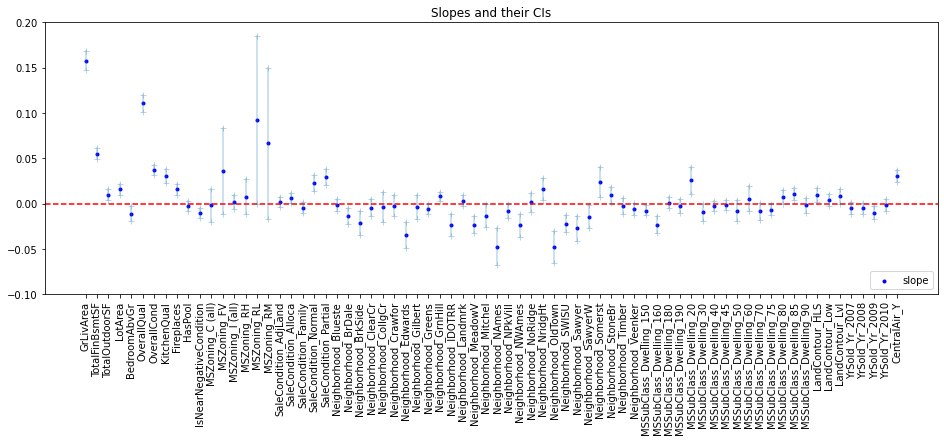

In [874]:
def plot_slope_CIs(df):
    plt.rcParams['figure.figsize'] = (10, 5)
    y_min, y_max = -0.1, 0.2

    table = pd.DataFrame(ans.summary().tables[1].data[1:])
    table.columns = ['name', 'coef', 'std err', 't value', 'p value', '2.5% confidence', '97.5% confidence']
    table = table.astype(
        {'name': str, 'coef': float, 'std err': float, 't value': float, 'p value': float, '2.5% confidence': float,
         '97.5% confidence': float})

    slope_table = table[['name', 'coef', '2.5% confidence', '97.5% confidence']].iloc[1:]
    slope_table.name = df.columns
    slope_table['y_min'] = slope_table['2.5% confidence'].map(lambda t: (t - y_min) / (y_max - y_min))
    slope_table['y_max'] = slope_table['97.5% confidence'].map(lambda t: (t - y_min) / (y_max - y_min))

    x = range(1, 1+len(df.columns))

    # Plot
    plt.figure(figsize=(16,5))
    plt.scatter(x=x, y=slope_table['coef'], label='slope', c='blue', marker='.')
    plt.axhline(0, linestyle='--', c='red')

    for i in x:
        plt.axvline(i, ymin=slope_table['y_min'][i], ymax=slope_table['y_max'][i], marker='+', alpha=0.3)
    plt.xticks(x, slope_table.name, rotation='vertical')
    plt.ylim((y_min, y_max))
    plt.title('Slopes and their CIs')
    plt.legend(loc=4)
    plt.show()

plot_slope_CIs(X)

In [875]:
# Score model
print(f"Coefficient of Determination training set: {round(model.score(X=X_train, y=y_train), 5)}")
print(f"Coefficient of Determination holdout set:  {round(model.score(X=X_test, y=y_test), 5)}")
print(f"MSE:                                       {round(mean_squared_error(y_true=y_test, y_pred=y_predict_test), 5)}")

Coefficient of Determination training set: 0.91847
Coefficient of Determination holdout set:  0.90203
MSE:                                       0.01502


In [876]:
# Beta coefficients and their effect
beta_names = np.insert(model.feature_names_in_, 0, "__Intercept__")

log_coefficients = np.insert(model.coef_, 0, model.intercept_)
unlogged_coefficients = np.insert(np.exp(model.coef_), 0, np.exp(model.intercept_))
effect = [(coeff-1) * ames.SalePrice.mean() for coeff in unlogged_coefficients]
effect[0] = 0

coeff_array = np.vstack([beta_names, log_coefficients, unlogged_coefficients, effect]).T
pd.DataFrame(coeff_array, columns=['Features', 'Coefficients (log)', 'Coefficients', 'Effect of 1-unit Change'])

,Features,Coefficients (log),Coefficients,Effect of 1-unit Change
0,__Intercept__,10.245873,28166.048147,0.0
1,GrLivArea,0.000323,1.000323,57.436247
2,TotalFinBsmtSF,0.000123,1.000123,21.842073
3,TotalOutdoorSF,0.00006,1.00006,10.644398
4,LotArea,0.000002,1.000002,0.365426
...,...,...,...,...
68,YrSold_Yr_2007,-0.011151,0.988911,-1971.890217
69,YrSold_Yr_2008,-0.013065,0.98702,-2308.158789
70,YrSold_Yr_2009,-0.024806,0.9755,-4356.83001
71,YrSold_Yr_2010,-0.004499,0.995511,-798.287521


In [877]:
# Residuals
model_residuals_test = y_test - y_predict_test
model_residuals_test.describe()

count    774.000000
mean       0.006764
std        0.122430
min       -1.435572
25%       -0.054603
50%        0.003554
75%        0.069845
max        0.545758
Name: LogSalePrice, dtype: float64

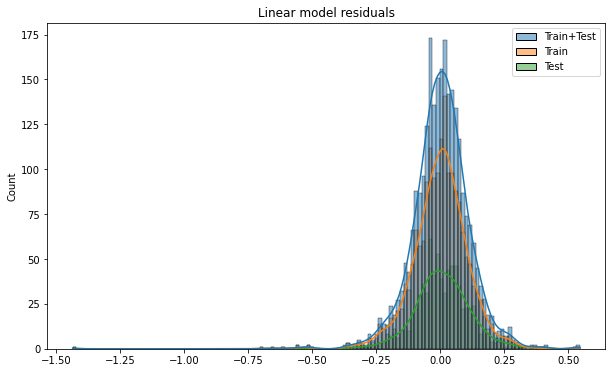

In [878]:
# Plot residuals
residuals_all = ames.LogSalePrice - model.predict(X)
residuals_train = y_train - model.predict(X_train)
residuals_test = y_test - model.predict(X_test)
residuals = pd.DataFrame({"Train+Test": residuals_all, "Train": residuals_train, "Test": residuals_test})

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(residuals, kde=True, ax=ax)
plt.title("Linear model residuals")
plt.show()

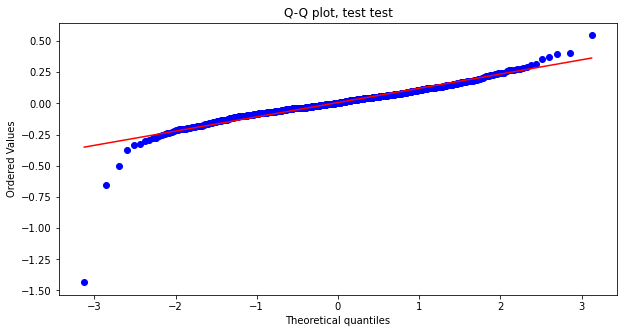

In [879]:
# Quantile-Quantile plot
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title("Q-Q plot, test test")
plt.show()

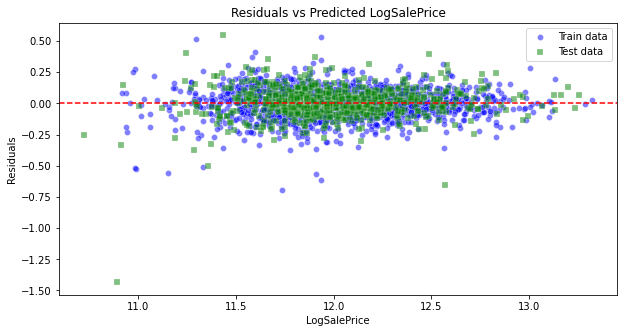

In [880]:
# Residuals vs Predicted LogSalePrice
sns.scatterplot(y=residuals_train, x=y_predict_train, color='blue', marker='o', alpha = 0.5, label="Train data")
sns.scatterplot(y=residuals_test, x=y_predict_test, color='green', marker='s', alpha=0.5, label="Test data")
plt.axhline(y=0, color="red", linestyle='--')
plt.title("Residuals vs Predicted LogSalePrice")
plt.ylabel("Residuals")
plt.xlabel("LogSalePrice")
plt.show()